# PyTorch Deep Learning Pipeline



In this part, we’ll walk through an end-to-end pipeline for a classification task on the MNIST dataset in Pytorch.

We will implement the following steps - 

1.   Download the dataset 
2. Load the dataset
2.   Define the model
1.   Define the loss function and optimizer
2.   Define the evaluation metric
1.   Train the network on the training data
2.   Report results on the train and test data (using the evaluation metric)


Reference - https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py


# Part 1: Download Data

In [ ]:
!pip install pypng

     |████████████████████████████████| 296kB 46.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/a4/cd/54/c1d0803dfed5adf2bba530eda161581d9096d0154aee082cac
Successfully built pypng


In [ ]:
from tqdm import *

In [ ]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!gunzip t*.gz

--2019-05-02 23:38:33--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yann.lecun.com)|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  5.88MB/s    in 1.6s    

2019-05-02 23:38:35 (5.88 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2019-05-02 23:38:36--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yann.lecun.com)|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[===================>]  28.20K   174KB/s    in 0.2s    

2019-05-02 23:38:37 (174 KB/s) - ‘train-labels-id

In [ ]:
# source: https://github.com/myleott/mnist_png/blob/master/convert_mnist_to_png.py
import os
import struct
import sys

from array import array
from os import path

import png

# source: http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
def read(dataset = "training", path = "."):
    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = array("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = array("B", fimg.read())
    fimg.close()

    return lbl, img, size, rows, cols

def write_dataset(labels, data, size, rows, cols, output_dir):
    # create output directories
    output_dirs = [
        path.join(output_dir, str(i))
        for i in range(10)
    ]
    for dir in output_dirs:
        if not path.exists(dir):
            os.makedirs(dir)

    # write data
    for (i, label) in tqdm(enumerate(labels)):
        output_filename = path.join(output_dirs[label], str(i) + ".png")
        with open(output_filename, "wb") as h:
            w = png.Writer(cols, rows, greyscale=True)
            data_i = [
                data[ (i*rows*cols + j*cols) : (i*rows*cols + (j+1)*cols) ]
                for j in range(rows)
            ]
            w.write(h, data_i)

input_path = '/content'
output_path = '/content/mnist'
for dataset in ["training", "testing"]:
    labels, data, size, rows, cols = read(dataset, input_path)
    write_dataset(labels, data, size, rows, cols,
                  path.join(output_path, dataset))

60000it [00:09, 6147.17it/s]
10000it [00:01, 6324.71it/s]


#Part 2: Load and preprocess the dataset 

In [ ]:
#Create csv files
import glob 
import pandas as pd

for split in ['training', 'testing']:
    rows = []
    for folder in glob.glob('/content/mnist/'+ split + '/*'):
        label = folder.split("/")[-1]
        for image_path in glob.glob(folder+ "/*"):
            rows.append([image_path,label])
    df=pd.DataFrame(rows,columns=['Path','Label'])
    df.to_csv(split + ".csv", index = False)


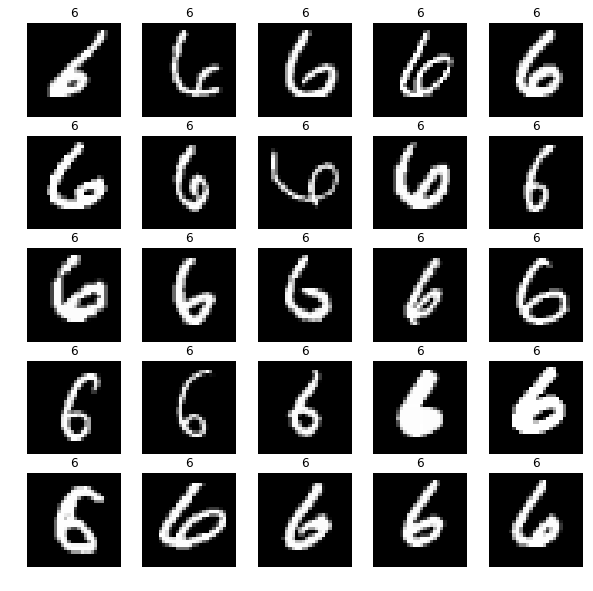

In [ ]:
# Visualize the dataset 

import matplotlib.pyplot as plt
import numpy as np
import cv2

def view_dataset(paths, labels, method='cv2'):
    fig, axs = plt.subplots(5, 5, figsize=(10, 10))
    flatted_axs = [item for one_ax in axs for item in one_ax]
    for ax, path, label in zip(flatted_axs, paths[:25], labels[:25]):
        if method == 'cv2':
            img = cv2.imread(path, 3)
        elif method == 'tf':
            img = try_tf_image(path)
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    plt.show() 


df = pd.read_csv('/content/training.csv')
paths = df['Path'][:25]
labels = df['Label'][:25]

view_dataset(paths, labels)

In [ ]:
# Install Pytorch2
# http://pytorch.org/
#from os.path import exists
#from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
#platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

  
!pip install torch 
import torch

print(torch.__version__)

1.0.1.post2


In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class Dataset(Dataset):
    def __init__(self, data_split, toy=False):
     
        df = pd.read_csv(data_split)
        
        # Remove any paths for which the image files do not exist
        #df = df[df["Path"].apply(os.path.exists)]
      
        #print ("%s size %d" % (data_split, df.shape[0]))

        #Could remove
        #if toy:
            #df = df.sample(frac=0.01)

        self.img_paths = df["Path"].tolist()

        self.labels = df["Label"].tolist()

        self.n_classes = len(self.labels)

    def __getitem__(self, index):
           img = np.array(Image.open(self.img_paths[index])).astype(np.float32) / 255.
           label = self.labels[index]
           label_vec = torch.LongTensor([label])
           return img, label_vec
          

    def __len__(self):
        return len(self.img_paths)

In [ ]:
train_dataset = Dataset('training.csv')
test_dataset = Dataset('testing.csv')


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100,
                                         shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100,
                                         shuffle=False)

print(len(train_loader))
print(len(test_loader))

600
100


In [ ]:
""" Step 2: Define the model

For now, we will implement a very simple 
2-layer neural network (LINEAR->RELU->LINEAR->SOFTMAX)
"""
import torch.nn as nn

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
      
model = nn.Sequential(
          Flatten(),
          nn.Linear(784, 50),
          nn.ReLU(),
          nn.Linear(50, 10),
          nn.Softmax())


In [ ]:
"""Step 3: Define loss function and optimizer

We will use the cross entropy loss and Adam optimizer
"""
import torch.optim as optim

# Define the cost function
criterion = nn.CrossEntropyLoss()

# Define the optimizer, learning rate 
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [ ]:
"""""Step 5: Train the network on the training data
"""

for epoch in range(2): 
      for i, (inputs, labels) in enumerate(train_loader, 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward propogation
        outputs = model(inputs)
        
        # calculate the loss
        loss = criterion(outputs, labels.squeeze(1))
        
        # backpropogation + update parameters
        loss.backward()
        optimizer.step()

        # print statistics
        cost = loss.item()
        if i % 100 == 0:    # print every 1000 iterations
            print('Epoch:' + str(epoch) + ", Iteration: " + str(i) 
                  + ", training cost = " + str(cost))


/usr/local/lib/python2.7/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch:0, Iteration: 0, training cost = 2.3012213707
Epoch:0, Iteration: 100, training cost = 1.57056260109
Epoch:0, Iteration: 200, training cost = 1.53760325909
Epoch:0, Iteration: 300, training cost = 1.53002023697
Epoch:0, Iteration: 400, training cost = 1.5536929369
Epoch:0, Iteration: 500, training cost = 1.5609023571
Epoch:1, Iteration: 0, training cost = 1.53286731243
Epoch:1, Iteration: 100, training cost = 1.51947629452
Epoch:1, Iteration: 200, training cost = 1.50253367424
Epoch:1, Iteration: 300, training cost = 1.5579059124
Epoch:1, Iteration: 400, training cost = 1.48810362816
Epoch:1, Iteration: 500, training cost = 1.53372812271


In [ ]:
"""Step 4: Define evaluation metric

We will use accuracy as an evaluation metric
"""

def calculate_accuracy(loader):
    total = 0
    correct = 0
  
    all_images = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.squeeze()).sum().item()
            
            all_images.append(images)
            all_preds.append(predicted.numpy())
            all_labels.append(labels)

    return 100 * correct / total, all_images, all_preds, all_labels

In [ ]:
"""Step 6: Report results on the train and test data (using the evaluation metric)
"""
        
train_accuracy, _ , _, _ = calculate_accuracy(train_loader)
test_accuracy, images, preds, labels = calculate_accuracy(test_loader)

print('Train accuracy: %f' % train_accuracy)
print('Test accuracy: %f' % test_accuracy)

images = np.concatenate(images, axis=0)
preds = np.concatenate(preds, axis=0)
labels = np.squeeze(np.concatenate(labels, axis=0))

Train accuracy: 94.000000
Test accuracy: 94.000000


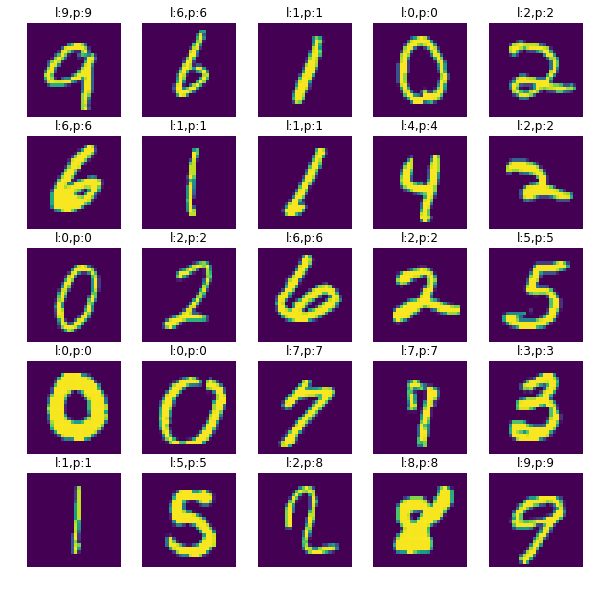

In [ ]:
##### VIEW PREDICTIONS #####
import matplotlib.pyplot as plt
import numpy as np


def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b) == len(c)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p]

images, labels, preds = unison_shuffled_copies(images, labels, preds)

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
flatted_axs = [item for one_ax in axs for item in one_ax]
for ax, img, label, pred in zip(flatted_axs, images[:25], labels[:25], preds[:25]):
    ax.imshow(np.reshape(img, (28,28)))
    ax.set_title('l:{},p:{}'.format(label, pred))
    ax.axis('off')
plt.show()  

# Part III - Saving/Loading a model

In this part, we will look at how you would save a trained model and then load it again for evaluation.

Reference - https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [ ]:
"""Save a model
"""

# Create a very simple model and save the weights
v1 = torch.randn(3)
v2 = torch.randn(5)

# Save variables
torch.save(v1, 'v1.pth')
torch.save(v2, 'v2.pth')

# Print values at v1 and v2 to verify later
print(v1)
print(v2)

In [ ]:
""" Load a model
"""

# Load variables v1 and v2 
v1 = torch.load('v1.pth')
v2 = torch.load('v2.pth')

# Check the values of the variables
print(v1)
print(v2)